Milestone-2 is all about "Medical Imaging Enhancement". It's objective is to use GenAI to enhance image quality and support diagnosis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import files
uploaded = files.upload()


Saving medical_images.zip to medical_images.zip


### As i have uploaded a zip file,so my first step is to extract the contents so that i can access the images. So in this step i will Create the extraction directory if it doesn't exist and then i will unzip the file.

In [3]:
import zipfile
import os
zip_file_path = 'medical_images.zip'
extract_dir = 'medical_images'
# Creating the extraction directory if it doesn't exist.
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Extracted dataset to '{extract_dir}'")


Extracted dataset to 'medical_images'


 ### Now as the dataset is extracted, i can explore the directory structure of the dataset to see how the images are organized.

In [4]:
extracted_contents = os.listdir(extract_dir)
print(f"Contents of '{extract_dir}':")
print(extracted_contents)
for item in extracted_contents:
    item_path = os.path.join(extract_dir, item)
    if os.path.isdir(item_path):
        print(f"\nContents of '{item_path}':")
        print(os.listdir(item_path))


Contents of 'medical_images':
['Dataset_BUSI_with_GT']

Contents of 'medical_images/Dataset_BUSI_with_GT':
['normal', 'benign', 'malignant']


### Now i will count the number of images in each category for class balance.

In [ ]:
# Defining the base directory (where the images of my dataset are stored).
base_dir = os.path.join(extract_dir, 'Dataset_BUSI_with_GT')
# Defining the categories.
categories = ['malignant', 'benign', 'normal']
# Creating a dictionary to store the counts.
image_counts = {}
for category in categories:
    category_dir = os.path.join(base_dir, category)
    if os.path.isdir(category_dir):
        # Listing all files in the directory.
        files_in_category = [f for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f))]
        image_counts[category] = len(files_in_category)
    else:
        image_counts[category] = 0
print("Number of images in each category:")
for category, count in image_counts.items():
    print(f"{category}: {count}")


Now i will apply GenAI. So for this, i have to first set the environment for GenAI by installing the required libraries.

In [5]:
!pip install tensorflow opencv-python scikit-image
import tensorflow as tf
from tensorflow import keras
import cv2
import skimage.metrics
import numpy as np
import os
import matplotlib.pyplot as plt


# Now i am loading the data and preprocessing it for model training.



In [10]:
base_dir = os.path.join(extract_dir, 'Dataset_BUSI_with_GT')
category_dir = os.path.join(base_dir, 'normal')
image_files = [os.path.join(category_dir, f) for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f))]
# Limit to a smaller subset.
subset_size = 10
sample_image_files = image_files[:subset_size]
# Function to load and preprocess images.
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB.
    img = img / 255.0  # Normalizing pixel values to [0, 1]
    img = tf.image.resize(img, (128, 128)) # Resizing images to a fixed size.
    return img
# Loading and preprocessing the sample images.
processed_images = [load_and_preprocess_image(f) for f in sample_image_files]
processed_images = tf.stack(processed_images)
print(f"Loaded and preprocessed {len(processed_images)} images.")
print(f"Shape of the processed images tensor: {processed_images.shape}")



Loaded and preprocessed 10 images.
Shape of the processed images tensor: (10, 128, 128, 3)


Now I have set up the environment, loaded and preprocessed a subset of the images. Now my next step is to choose a suitable GenAI Model for image denoising. There are various architecture that can be used for the work but here I am using GANs (Generative Adversarial Networks). It can be trained to generate realistic images and that can be adopted for denoising by training a generator to produce clean images from the noisy ones.

Now I have to define the discriminator model. Because this model will try to distinguish between the real/clean images and the fake/denoised images generated by the generator.

In [11]:
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Flatten, Dense
from tensorflow.keras.models import Model
def build_discriminator():
    # Input layer
    input_img = Input(shape=(128, 128, 3))
    # Discriminator layers
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(input_img)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(512, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    # Flatten and dense layers.
    x = Flatten()(x)
    output_prob = Dense(1, activation='sigmoid')(x) # probability of the output for being real or fake.
    model = Model(inputs=input_img, outputs=output_prob, name='discriminator')
    return model
# Creating an instance of the discriminator model.
discriminator = build_discriminator()
discriminator.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 512)      │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,792,897 (10.65 MB)

 Trainable params: 2,791,105 (10.65 MB)

 Non-trainable params: 1,792 (7.00 KB)

Now I can continue the image reconstruction task . The next step is to define the loss function and the optimizers for the GANs.

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
# Defining loss functions.
cross_entropy = BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output, real_images, fake_images, reconstruction_weight=100):
    adversarial_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    reconstruction_loss = tf.reduce_mean(tf.abs(real_images - fake_images))
    total_loss = adversarial_loss + reconstruction_weight * reconstruction_loss
    return total_loss
# Defining optimizers.
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)



Now I will write code for better clarity and better visualization of the images and then I will do a visual comparison between original and enhanced images.

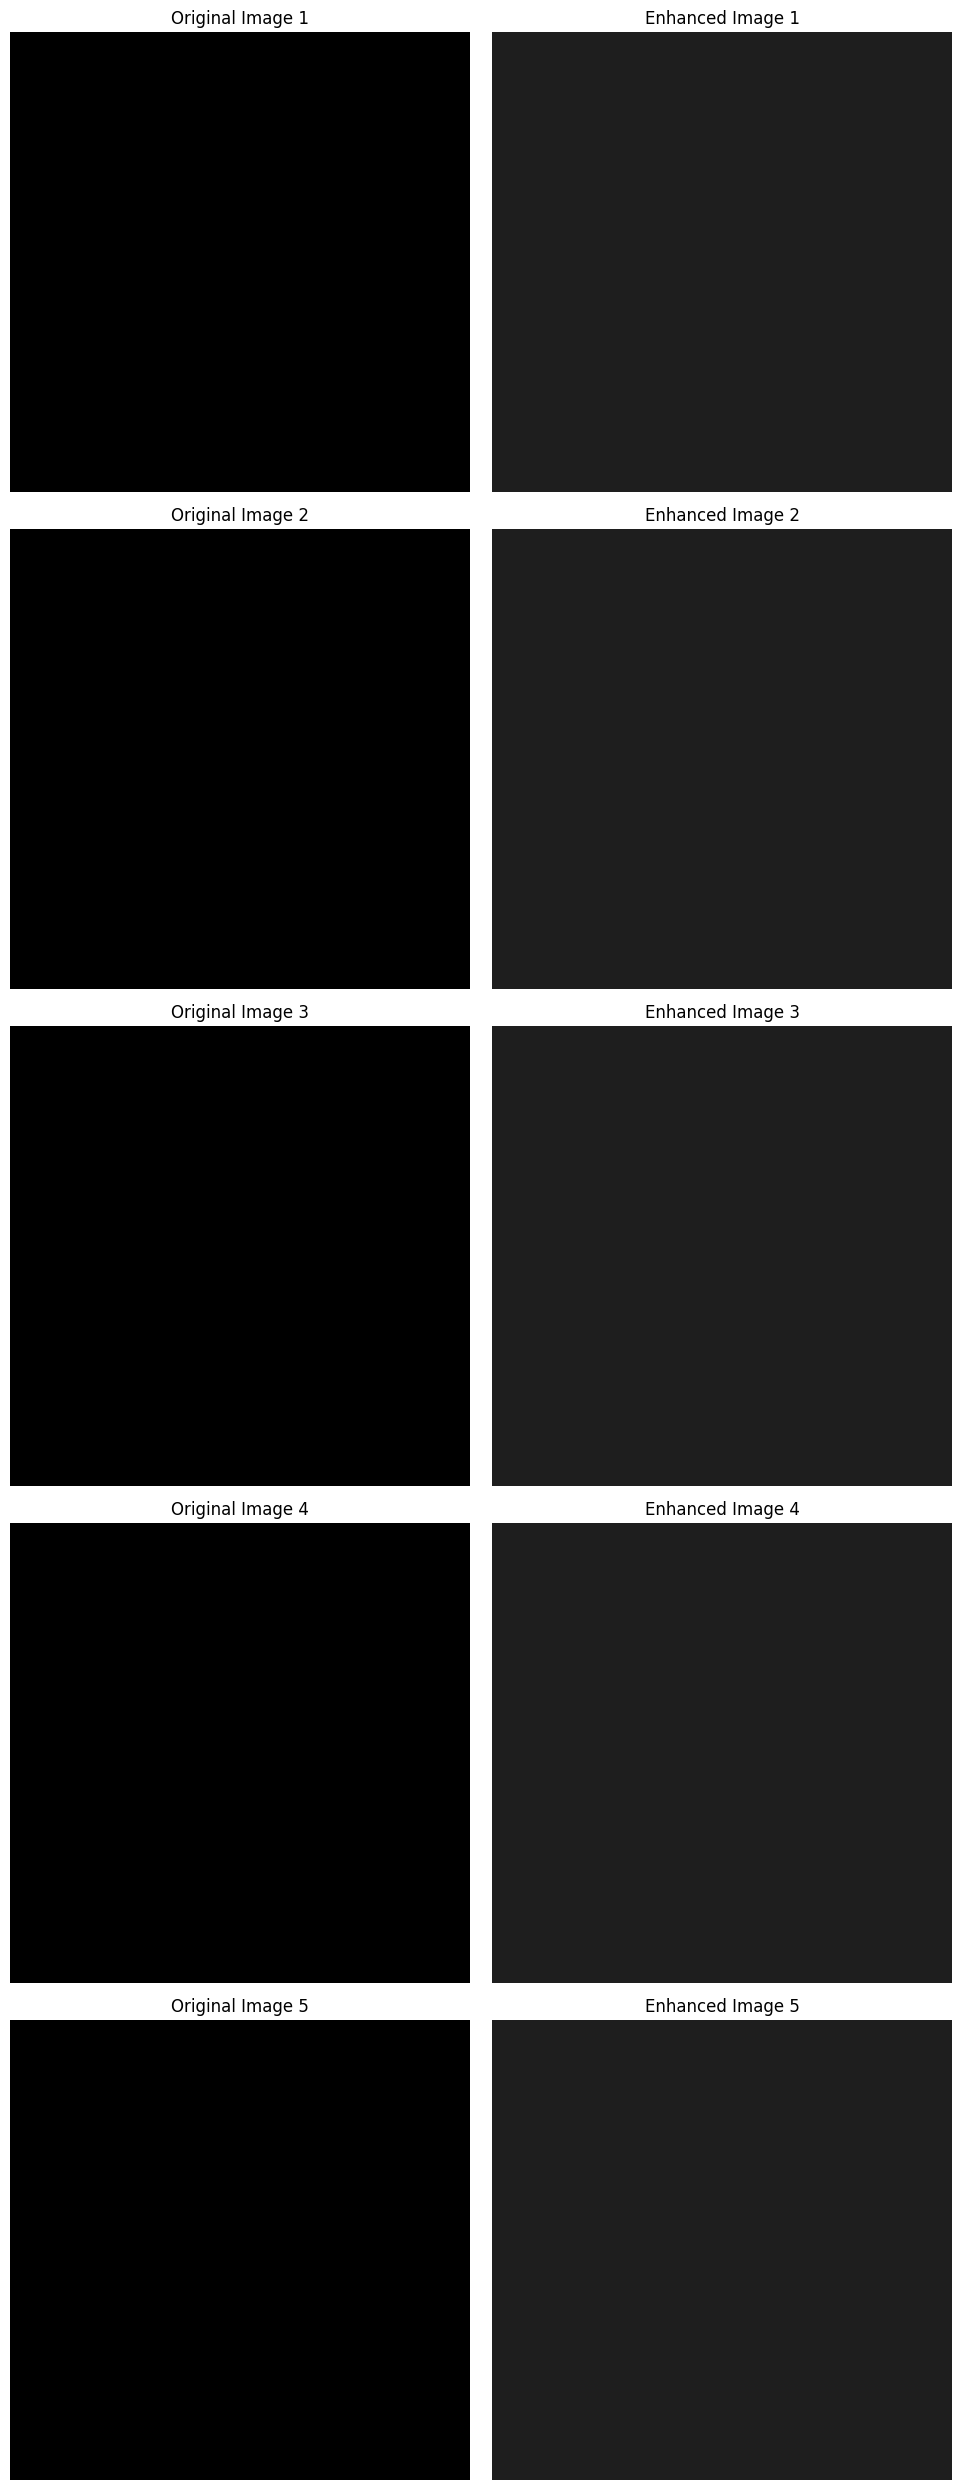

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Adjusting brightness and contrast.
def enhance_image(image, alpha=1.0, beta=0):
    # Converting float [0, 1] to uint8 [0, 255].
    image_uint8 = (image * 255).astype(np.uint8)
    enhanced_image_uint8 = cv2.convertScaleAbs(image_uint8, alpha=alpha, beta=beta)
    # Convert back to float [0, 1].
    enhanced_image_float = enhanced_image_uint8 / 255.0
    return enhanced_image_float
# Displaying a visual comparison of original and enhanced images.
num_images_to_display = 5
if len(processed_images) >= num_images_to_display:
    fig, axes = plt.subplots(num_images_to_display, 2, figsize=(10, num_images_to_display * 5))
    for i in range(num_images_to_display):
        sample_image = processed_images[i].numpy() # Converting tensor to numpy array.
        enhanced_sample_image = enhance_image(sample_image, alpha=1.5, beta=30)
        # Displaying original images.
        if sample_image.ndim == 3 and sample_image.shape[2] == 3:
            axes[i, 0].imshow(sample_image)
            axes[i, 0].set_title(f"Original Image {i+1}")
            axes[i, 0].axis('off')
        else:
            axes[i, 0].set_title(f"Original Image {i+1} (Cannot Display)")
            axes[i, 0].axis('off')
            print(f"Warning: Original image {i+1} has unexpected dimensions for display.")
        # Displaying enhanced image.
        if enhanced_sample_image.ndim == 3 and enhanced_sample_image.shape[2] == 3:
            axes[i, 1].imshow(enhanced_sample_image)
            axes[i, 1].set_title(f"Enhanced Image {i+1}")
            axes[i, 1].axis('off')
        else:
             axes[i, 1].set_title(f"Enhanced Image {i+1} (Cannot Display)")
             axes[i, 1].axis('off')
             print(f"Warning: Enhanced image {i+1} has unexpected dimensions for display.")
    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough processed images available to display {num_images_to_display} comparisons.")

Now I will code to calculate PSNR (Peak Signal-to-Noised Ratio) for the images before and after enhancement. As we know, PSNR is used to measure the quality of a reconstructed image in comparison to original one.

In [14]:
import skimage.metrics
import numpy as np
# Calculating and printing PSNR for original vs. enhanced images
num_images_to_evaluate = 5
if len(processed_images) >= num_images_to_evaluate:
    print(f"Calculating PSNR for {num_images_to_evaluate} image pairs (Original vs. Enhanced):")
    for i in range(num_images_to_evaluate):
        original_image = processed_images[i].numpy()
        enhanced_image = enhance_image(original_image, alpha=1.5, beta=30)
        psnr = skimage.metrics.peak_signal_noise_ratio(original_image, enhanced_image, data_range=1.0)
        print(f"  Image {i+1}: PSNR = {psnr:.4f}")
else:
    print(f"Not enough processed images available to evaluate PSNR for {num_images_to_evaluate} comparisons.")


Calculating PSNR for 5 image pairs (Original vs. Enhanced):
  Image 1: PSNR = 18.5884
  Image 2: PSNR = 18.5884
  Image 3: PSNR = 18.5884
  Image 4: PSNR = 18.5884
  Image 5: PSNR = 18.5884


Now I will generate code for loading, enhancing and preparing the data for classification.

In [23]:

import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
base_dir = os.path.join('medical_images', 'Dataset_BUSI_with_GT')
categories = ['malignant', 'benign', 'normal']

# Function to load, enhance, and prepare data for classification
def load_enhance_and_prepare_data(base_dir, categories, alpha=1.5, beta=30):
    images = []
    labels = []
    label_map = {category: i for i, category in enumerate(categories)} # Creating a mapping from category name to integer label.

    for category in categories:
        category_dir = os.path.join(base_dir, category)
        if os.path.isdir(category_dir):
            image_files = [os.path.join(category_dir, f) for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            for image_file in image_files:
                # Image loading.
                img = cv2.imread(image_file, cv2.IMREAD_COLOR)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = img / 255.0
                    # Apply enhancement
                    enhanced_img = enhance_image(img, alpha=alpha, beta=beta)
                    resized_img = tf.image.resize(enhanced_img, (128, 128)).numpy() # Convert back to numpy after resize
                    images.append(resized_img)
                    labels.append(label_map[category])
    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, label_map
# Load, enhance, and prepare the entire dataset
enhanced_images, labels, label_map = load_enhance_and_prepare_data(base_dir, categories, alpha=1.5, beta=30)
print(f"Loaded and enhanced {len(enhanced_images)} images with labels.")
print(f"Shape of enhanced images array: {enhanced_images.shape}")
print(f"Shape of labels array: {labels.shape}")
print(f"Label mapping: {label_map}")
# Split data into training, validation, and test sets
# Using stratify=labels to maintain the proportion of classes in each split
X_train, X_temp, y_train, y_temp = train_test_split(enhanced_images, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp) # Split temp into val and test
print(f"\nTraining set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Loaded and enhanced 1148 images with labels.
Shape of enhanced images array: (1148, 128, 128, 3)
Shape of labels array: (1148,)
Label mapping: {'malignant': 0, 'benign': 1, 'normal': 2}

Training set shape: (803, 128, 128, 3), (803,)
Validation set shape: (172, 128, 128, 3), (172,)
Test set shape: (173, 128, 128, 3), (173,)


Now I will build the image classification model.


In [24]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
def build_classification_model(input_shape=(128, 128, 3), num_classes=3):
    # Input layer
    input_img = Input(shape=input_shape)
    # Convolutional layers
    x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(input_img)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2)(x)
    # Flatten layer
    x = Flatten()(x)
    # Dense layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    # Output layer
    output_prob = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_img, outputs=output_prob, name='image_classification_model')
    return model
# Defining the input shape and number of classes based on our data.
input_shape = (128, 128, 3) # Based on the resizing in the previous step.
num_classes = len(label_map) # Based on the number of categories.
# Building the classification model.
classification_model = build_classification_model(input_shape=input_shape, num_classes=num_classes)
classification_model.summary()

Model: "image_classification_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,482,883 (32.36 MB)

 Trainable params: 8,482,883 (32.36 MB)

 Non-trainable params: 0 (0.00 B)

Now I will compile the image classification model.

In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
# Compiling the classification model.
classification_model.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
print("Classification model compiled successfully.")

Classification model compiled successfully.


Now after compilation is completed, I will train it using our enhanced image data . And for this I will use the training and validation sets.

In [26]:
# Training the classification model.
EPOCHS_CLASSIFICATION = 10
BATCH_SIZE_CLASSIFICATION = 32
print(f"Starting training for {EPOCHS_CLASSIFICATION} epochs with batch size {BATCH_SIZE_CLASSIFICATION}...")
history = classification_model.fit(X_train, y_train,  epochs=EPOCHS_CLASSIFICATION, batch_size=BATCH_SIZE_CLASSIFICATION,validation_data=(X_val, y_val))
print("Training finished.")

Starting training for 10 epochs with batch size 32...
Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.4050 - loss: 1.1132 - val_accuracy: 0.4709 - val_loss: 0.9326
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4989 - loss: 0.8819 - val_accuracy: 0.6047 - val_loss: 0.8821
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6354 - loss: 0.7540 - val_accuracy: 0.6512 - val_loss: 0.7780
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7301 - loss: 0.6209 - val_accuracy: 0.6686 - val_loss: 0.8055
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.8098 - loss: 0.4816 - val_accuracy: 0.6860 - val_loss: 0.8564
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8132 - loss: 0.4453 - val_accuracy: 0.6744 - val_loss: 0.9463
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8764 - loss: 0.3215 - val_accuracy: 0.7093 - val_loss: 0.9270
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.

After the classification model has been trained successfully, in my very next step I will evaluate it's performance on the test set to see how well it generalizes to unseen data.

In [27]:
print("Evaluating the classification model on the test set...")
loss, accuracy = classification_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Evaluating the classification model on the test set...
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - accuracy: 0.7436 - loss: 1.3033
Test Loss: 1.3957
Test Accuracy: 0.7225


In [28]:
# Making predictions on a few test images.
num_predictions_to_show = 5
if len(X_test) >= num_predictions_to_show:
    sample_test_images = X_test[:num_predictions_to_show]
    sample_test_labels = y_test[:num_predictions_to_show]
    predictions = classification_model.predict(sample_test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    print(f"Making predictions on {num_predictions_to_show} test images:")
    for i in range(num_predictions_to_show):
        true_label = list(label_map.keys())[list(label_map.values()).index(sample_test_labels[i])]
        predicted_label = list(label_map.keys())[list(label_map.values()).index(predicted_classes[i])]
        print(f"  Image {i+1}: True Label: {true_label}, Predicted Label: {predicted_label}")
else:
    print(f"Not enough test images available to show {num_predictions_to_show} predictions.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Making predictions on 5 test images:
  Image 1: True Label: malignant, Predicted Label: malignant
  Image 2: True Label: normal, Predicted Label: normal
  Image 3: True Label: benign, Predicted Label: benign
  Image 4: True Label: malignant, Predicted Label: malignant
  Image 5: True Label: benign, Predicted Label: benign


 Now i will Visualize some predictions along with their true and predicted labels to see how well the model is performing on individual images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


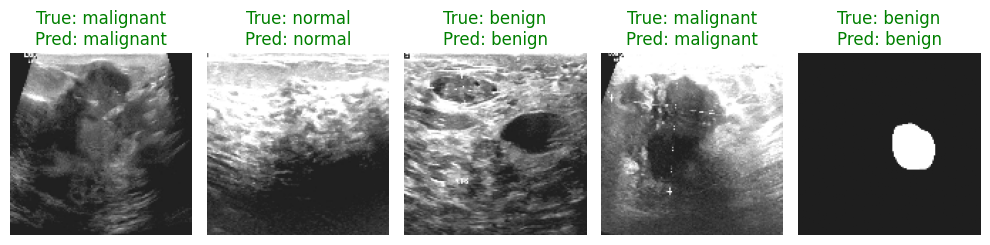

In [29]:
num_predictions_to_show = 5
if len(X_test) >= num_predictions_to_show:
    sample_test_images = X_test[:num_predictions_to_show]
    sample_test_labels = y_test[:num_predictions_to_show]
    predictions = classification_model.predict(sample_test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    plt.figure(figsize=(10, 10))
    for i in range(num_predictions_to_show):
        plt.subplot(1, num_predictions_to_show, i + 1)
        plt.imshow(sample_test_images[i])
        true_label = list(label_map.keys())[list(label_map.values()).index(sample_test_labels[i])]
        predicted_label = list(label_map.keys())[list(label_map.values()).index(predicted_classes[i])]
        color = 'green' if true_label == predicted_label else 'red'
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough test images available to visualize {num_predictions_to_show} predictions.")

Now i will code for "Decision Tree Model". As we know , Decision Trees work with tabular data, so i have to flatten the image data first.Now i will build, train and evaluate a Decision Tree Model.

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
# Flattening the image data for the Decision Tree.
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
print(f"Flattened training data shape: {X_train_flat.shape}")
print(f"Flattened validation data shape: {X_val_flat.shape}")
print(f"Flattened test data shape: {X_test_flat.shape}")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)
print("\nData scaled.")

# Building the Decision Tree Classifier model.
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Training the model.
print("\nTraining the Decision Tree model...")
decision_tree_model.fit(X_train_scaled, y_train)
print("Training complete.")

# Evaluating the model.
print("\nEvaluating the model on the test set...")
y_pred = decision_tree_model.predict(X_test_scaled)

# Printing evaluation metrics.
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Flattened training data shape: (803, 49152)
Flattened validation data shape: (172, 49152)
Flattened test data shape: (173, 49152)

Data scaled.

Training the Decision Tree model...
Training complete.

Evaluating the model on the test set...
Classification Report:
              precision    recall  f1-score   support

   malignant       0.64      0.53      0.58        64
      benign       0.55      0.61      0.58        70
      normal       0.60      0.64      0.62        39

    accuracy                           0.59       173
   macro avg       0.60      0.60      0.59       173
weighted avg       0.59      0.59      0.59       173

Confusion Matrix:
[[34 28  2]
 [12 43 15]
 [ 7  7 25]]


Now i will build the Convolutional Neural Network (CNN) model. These are generally much more efficient and effective for image classification because they can directly process the informations in images.

In [31]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
def build_classification_model(input_shape=(128, 128, 3), num_classes=3):
    # Input layer
    input_img = Input(shape=input_shape)
    # Convolutional layers
    x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(input_img)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2)(x)
    # Flatten layer
    x = Flatten()(x)
    # Dense layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    # Output layer
    output_prob = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_img, outputs=output_prob, name='image_classification_model')
    return model
# Defining the input shape and number of classes based on our data.
input_shape = (128, 128, 3)
num_classes = len(label_map)
# Building the classification model.
classification_model = build_classification_model(input_shape=input_shape, num_classes=num_classes)
classification_model.summary()

Model: "image_classification_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,482,883 (32.36 MB)

 Trainable params: 8,482,883 (32.36 MB)

 Non-trainable params: 0 (0.00 B)

 As CNN model architecture is defined, in my next step i will compile it. Which involves specifying the optimizer, the loss function, and the metrics to evaluate during training.

In [32]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
# Compiling the classification model.
classification_model.compile(optimizer=Adam(learning_rate=0.001),loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
print("Classification model compiled successfully.")


Classification model compiled successfully.


# As the classification model is compiled and ready for training ,in the next step i will train the CNN model using my prepared training data and validate it using the validation set. Here the model will learn to classify the images.


In [33]:
history = classification_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))
print("\nClassification model training complete.")

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4378 - loss: 1.5726 - val_accuracy: 0.4826 - val_loss: 0.9210
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5111 - loss: 0.8830 - val_accuracy: 0.6512 - val_loss: 0.8961
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6757 - loss: 0.8075 - val_accuracy: 0.6512 - val_loss: 0.8188
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7256 - loss: 0.6457 - val_accuracy: 0.6686 - val_loss: 0.7693
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7871 - loss: 0.5203 - val_accuracy: 0.6744 - val_loss: 0.7999

Classification model training complete.


Now the CNN model has been trained, so i will evaluate it's performance on the test set. This will give an idea of how well the model generalizes to new data.


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
# Evaluating the model on the test set.
print("Evaluating the classification model on the test set...")
loss, accuracy = classification_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
y_pred_probs = classification_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
# Printing classification report.
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=categories))
# Printing confusion matrix.
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Evaluating the classification model on the test set...

Test Loss: 0.8763
Test Accuracy: 0.6185
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 682ms/step

Classification Report:
              precision    recall  f1-score   support

   malignant       0.52      0.75      0.61        64
      benign       0.66      0.59      0.62        70
      normal       1.00      0.46      0.63        39

    accuracy                           0.62       173
   macro avg       0.73      0.60      0.62       173
weighted avg       0.68      0.62      0.62       173


Confusion Matrix:
[[48 16  0]
 [29 41  0]
 [16  5 18]]


Now i will write code for Random Forest Classifier.It is a tree based model which worls with tabular data. Now i will build, train, and evaluate a Random Forest model on my flattened image data.

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
# Training the model.
print("Training the Random Forest model...")
random_forest_model.fit(X_train_scaled, y_train)
print("Training complete.")

# Evaluating the model on the test set.
print("\nEvaluating the model on the test set...")
y_pred_rf = random_forest_model.predict(X_test_scaled)

# Printing evaluation metrics.
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=categories))
print("Confusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))

Training the Random Forest model...
Training complete.

Evaluating the model on the test set...
Classification Report (Random Forest):
              precision    recall  f1-score   support

   malignant       0.65      0.67      0.66        64
      benign       0.61      0.67      0.64        70
      normal       0.70      0.54      0.61        39

    accuracy                           0.64       173
   macro avg       0.65      0.63      0.64       173
weighted avg       0.65      0.64      0.64       173

Confusion Matrix (Random Forest):
[[43 21  0]
 [14 47  9]
 [ 9  9 21]]


Now i will write code for Logistic Regression, which is a linear model and requires flattened data.Now i am writing the code to build, train, and evaluate a Logistic Regression model on my scaled, flattened image data.

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
logistic_regression_model = LogisticRegression(max_iter=1000, random_state=42)
# Training the model.
print("Training the Logistic Regression model...")
logistic_regression_model.fit(X_train_scaled, y_train)
print("Training complete.")

# Evaluating the model on the test set.
print("\nEvaluating the model on the test set...")
y_pred_lr = logistic_regression_model.predict(X_test_scaled)

# Printing evaluation metrics.
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr, target_names=categories))
print("Confusion Matrix (Logistic Regression):")
print(confusion_matrix(y_test, y_pred_lr))

Training the Logistic Regression model...
Training complete.

Evaluating the model on the test set...
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

   malignant       0.50      0.41      0.45        64
      benign       0.44      0.43      0.43        70
      normal       0.40      0.54      0.46        39

    accuracy                           0.45       173
   macro avg       0.45      0.46      0.45       173
weighted avg       0.45      0.45      0.44       173

Confusion Matrix (Logistic Regression):
[[26 30  8]
 [16 30 24]
 [10  8 21]]


Now i will the code for a K-Nearest Neighbors (KNN) model.

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
knn_model = KNeighborsClassifier(n_neighbors=5)
# Training the model.
print("Training the K-Nearest Neighbors model...")
knn_model.fit(X_train_scaled, y_train)
print("Training complete.")

# Evaluating the model on the test set.
print("\nEvaluating the K-Nearest Neighbors model on the test set...")
y_pred_knn = knn_model.predict(X_test_scaled)

# Printing evaluation metrics.
print("Classification Report (K-Nearest Neighbors):")
print(classification_report(y_test, y_pred_knn, target_names=categories))
print("Confusion Matrix (K-Nearest Neighbors):")
print(confusion_matrix(y_test, y_pred_knn))


Training the K-Nearest Neighbors model...
Training complete.

Evaluating the K-Nearest Neighbors model on the test set...
Classification Report (K-Nearest Neighbors):
              precision    recall  f1-score   support

   malignant       0.60      0.70      0.65        64
      benign       0.68      0.54      0.60        70
      normal       0.64      0.69      0.67        39

    accuracy                           0.64       173
   macro avg       0.64      0.65      0.64       173
weighted avg       0.64      0.64      0.63       173

Confusion Matrix (K-Nearest Neighbors):
[[45 16  3]
 [20 38 12]
 [10  2 27]]


Now i will write code for a Support Vector Machine (SVM) model. These are another powerful classification algorithm that can work well with various types of data, including flattened image features.



In [39]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
svm_model = SVC(kernel='rbf', random_state=42)
# Training the model.
print("Training the Support Vector Machine model...")
svm_model.fit(X_train_scaled, y_train)
print("Training complete.")

# Evaluating the model on the test set.
print("\nEvaluating the Support Vector Machine model on the test set...")
y_pred_svm = svm_model.predict(X_test_scaled)

# Printing evaluation metrics.
print("Classification Report (Support Vector Machine):")
print(classification_report(y_test, y_pred_svm, target_names=categories))
print("Confusion Matrix (Support Vector Machine):")
print(confusion_matrix(y_test, y_pred_svm))

Training the Support Vector Machine model...
Training complete.

Evaluating the Support Vector Machine model on the test set...
Classification Report (Support Vector Machine):
              precision    recall  f1-score   support

   malignant       0.69      0.69      0.69        64
      benign       0.58      0.63      0.60        70
      normal       0.64      0.54      0.58        39

    accuracy                           0.63       173
   macro avg       0.63      0.62      0.62       173
weighted avg       0.63      0.63      0.63       173

Confusion Matrix (Support Vector Machine):
[[44 19  1]
 [15 44 11]
 [ 5 13 21]]
